#CONVNEXT ON TRANSFORMATIONS

In [ ]:
%cd /content
!unzip /content/drive/MyDrive/Grayscale.zip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
# import timm


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.transforms import v2
import re

class ImageNetValidation(Dataset):
    def __init__(self, root_dir, ground_truth_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_names = sorted(os.listdir(root_dir))

        # Load ground truth labels
        with open(ground_truth_file, 'r') as f:
            self.labels = [int(line.strip()) for line in f]

    def _load_image(self, path):
    # try:
        im = Image.open(path)
        im = im.resize((224,224))
        # except:
        #     print("ERROR IMG LOADED: ", path)
        #     random_img = np.random.rand(224, 224, 3) * 255
        #     im = Image.fromarray(np.uint8(random_img))
        return im

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_names[idx])
            # Regular expression pattern to match the numeric segment
        pattern = r'_0*(\d+)\.'

        # Search for the pattern in the filename
        match = re.search(pattern, img_path)

        if match:
            # Extract and return the captured number
            index = int(match.group(1))


        image = self._load_image(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        #print("index:",index,"label:",self.labels[index - 1])

        return image, torch.tensor(self.labels[index - 1])

    def __len__(self):
        return len(self.img_names)


transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset
val_dataset = ImageNetValidation(
    root_dir='/content/Grayscale',
    ground_truth_file='/content/mapped_values.txt',
    transform=transforms
)

# Create the DataLoader
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
batch_size = 1
sampler = torch.utils.data.SequentialSampler(val_dataset)
val_loader = torch.utils.data.DataLoader(
        val_dataset, sampler=sampler,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
        drop_last=False
)

In [ ]:
val_dataset[152]

In [ ]:
print(len(val_dataset))  # Check the number of images in the dataset
print(len(val_loader))  # Check the number of batches in the DataLoader


In [ ]:
# Load the pretrained ConvNeXt model
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)
model.eval()


In [ ]:
!pip install timm

In [ ]:
mkdir /content/res

#CODE FOR LOGGING

In [ ]:
##CODE FOR LOGGING
def reduce_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= dist.get_world_size()
    return rt

import os
import sys
import logging
import functools
from termcolor import colored


@functools.lru_cache()
def create_logger(output_dir, dist_rank=0, name=''):
    # create logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.DEBUG)
    logger.propagate = False

    # create formatter
    fmt = '[%(asctime)s %(name)s] (%(filename)s %(lineno)d): %(levelname)s %(message)s'
    color_fmt = colored('[%(asctime)s %(name)s]', 'green') + \
                colored('(%(filename)s %(lineno)d)', 'yellow') + ': %(levelname)s %(message)s'

    # create console handlers for master process
    if dist_rank == 0:
        console_handler = logging.StreamHandler(sys.stdout)
        console_handler.setLevel(logging.DEBUG)
        console_handler.setFormatter(
            logging.Formatter(fmt=color_fmt, datefmt='%Y-%m-%d %H:%M:%S'))
        logger.addHandler(console_handler)

    # create file handlers
    file_handler = logging.FileHandler(os.path.join(output_dir, f'log_rank_grayscale_convnext.txt'), mode='a')
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(logging.Formatter(fmt=fmt, datefmt='%Y-%m-%d %H:%M:%S'))
    logger.addHandler(file_handler)

    return logger

logger = create_logger(output_dir="/content/res", name="b")

#CODE FOR VALIDATION/EVALUATION

In [ ]:
##CODE FOR VALIDATION/EVALUATION
import torch
import time
from timm.utils import accuracy, AverageMeter
import torch.distributed as dist

def reduce_tensor(tensor):
    rt = tensor.clone()
    dist.all_reduce(rt, op=dist.ReduceOp.SUM)
    rt /= dist.get_world_size()
    return rt

@torch.no_grad()
def validate(model, data_loader):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()

    res_model = []
    res_tar = []
    dict = {}

    batch_time = AverageMeter()
    loss_meter = AverageMeter()
    acc1_meter = AverageMeter()
    acc5_meter = AverageMeter()

    end = time.time()
    for idx, (images, target) in enumerate(data_loader):
        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)
        print(idx)
        # print(images)
        # print(target)
        # break

        #compute output
        with torch.cuda.amp.autocast(enabled=False):
            output = model(images)

        res_model.append(np.argmax(output.cpu().detach().numpy(), axis=1))
        res_tar.append(target.cpu().detach().numpy())

        # print(res_model)
        # print(res_tar)

        # measure accuracy and record loss
        loss = criterion(output, target)
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        t = target.cpu().detach().numpy()
        # print(t, target, acc1.item())
        t = int(t[0])
        if t in dict:
          dict[t].append(acc1.item())
        else:
          dict[t] = [acc1.item()]
        # print(dict)

        # print(acc1, acc5)
        print(acc1, acc5)

        # acc1 = reduce_tensor(acc1)
        # acc5 = reduce_tensor(acc5)
        # loss = reduce_tensor(loss)

        # print(acc1, acc5)

        loss_meter.update(loss.item(), target.size(0))
        acc1_meter.update(acc1.item(), target.size(0))
        acc5_meter.update(acc5.item(), target.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if idx % 2 == 0:
            memory_used = torch.cuda.max_memory_allocated() / (1024.0 * 1024.0)
            logger.info(
                f'Test: [{idx}/{len(data_loader)}]\t'
                f'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                f'Loss {loss_meter.val:.4f} ({loss_meter.avg:.4f})\t'
                f'Acc@1 {acc1_meter.val:.3f} ({acc1_meter.avg:.3f})\t'
                f'Acc@5 {acc5_meter.val:.3f} ({acc5_meter.avg:.3f})\t'
                f'Mem {memory_used:.0f}MB')
    logger.info(f' * Acc@1 {acc1_meter.avg:.3f} Acc@5 {acc5_meter.avg:.3f}')
    with open("New_grayscale.json", 'w') as new_file:
        json.dump(dict, new_file, indent=4)
    return acc1_meter.avg, acc5_meter.avg, loss_meter.avg, res_model, res_tar

In [ ]:
import numpy as np
import json
device = torch.device("cuda")
result = validate(model.to(device), val_loader)

Streaming output truncated to the last 5000 lines.
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
[2024-08-06 13:16:01 b](<ipython-input-25-9aa58cdf28e7> 77): INFO Test: [13572/15000]	Time 0.028 (0.039)	Loss 4.3303 (2.4036)	Acc@1 0.000 (62.705)	Acc@5 0.000 (74.722)	Mem 367MB
[2024-08-06 13:16:01 b](<ipython-input-25-9aa58cdf28e7> 77): INFO Test: [13572/15000]	Time 0.028 (0.039)	Loss 4.3303 (2.4036)	Acc@1 0.000 (62.705)	Acc@5 0.000 (74.722)	Mem 367MB
[2024-08-06 13:16:01 b](<ipython-input-25-9aa58cdf28e7> 77): INFO Test: [13572/15000]	Time 0.028 (0.039)	Loss 4.3303 (2.4036)	Acc@1 0.000 (62.705)	Acc@5 0.000 (74.722)	Mem 367MB
13573
tensor(0., device='cuda:0') tensor(0., device='cuda:0')
13574
tensor(100., device='cuda:0') tensor(100., device='cuda:0')
[2024-08-06 13:16:01 b](<ipython-input-25-9aa58cdf28e7> 77): INFO Test: [13574/15000]	Time 0.033 (0.039)	Loss 1.1715 (2.4039)	Acc@1 100.000 (62.703)	Acc@5 100.000 (74.718)	Mem 367MB
[2024-08-06 13:16:01 b](<ipython-input-25-9aa58cd

In [ ]:
# prompt: write a code to iterate through the values(that are accuracies) of each key in a json file and calculate the average(accuracy) against each key and store them as a value against the key in the same json file. Make sure to not erase the previous values in the json against each key

with open("/content/New.json", 'r+') as file:
    data = json.load(file)
    for key in data:
        avg = sum(data[key]) / len(data[key])
        data[key].append(avg)
    file.seek(0)
    json.dump(data, file, indent=4)
    file.truncate()


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.transforms import v2
import re
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def _load_image(path):
# try:
    im = Image.open(path)
    im = im.resize((224,224))
    # except:
    #     print("ERROR IMG LOADED: ", path)
    #     random_img = np.random.rand(224, 224, 3) * 255
    #     im = Image.fromarray(np.uint8(random_img))
    return im
img_path = "/content/ILSVRC2012_val_00000001.JPEG"
image = _load_image(img_path).convert('RGB')

image = transforms(image)

#CODE FOR INTERMEDIATE LAYER REPRESENTATIONS EXTRACTION USING FORWARD HOOK

In [ ]:
##CODE FOR INTERMEDIATE LAYER REPRESENTATIONS USING FORWARD HOOK
import torch
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
import json
outputs = {}

# Hook function to store the output
def hook(module, input, output):
    outputs[module] = output.detach().cpu().numpy()

# Register hook to a specific layer
layer = model.features[1][0]  # CHOOSE A LAYER
hook_handle = layer.register_forward_hook(hook)

# Run inference on the single image
# model.eval()
# with torch.no_grad():
#     output = model(image.unsqueeze(0))

# # Print the shape of the captured representation
# for module, output in outputs.items():
#     print(f'Layer: {module}')
#     print(f'Output shape: {output.shape}')

# # Convert representations to a serializable format
# representations = {str(module): output.tolist() for module, output in outputs.items()}

# # Save to JSON file
# with open('single_image_representations.json', 'w') as f:
#     json.dump(representations, f)

# print("Representations saved to single_image_representations.json")

# # Remove the hook
# hook_handle.remove()
model.eval()
with torch.no_grad():
    image = image.cuda(non_blocking=True)
    with torch.cuda.amp.autocast(enabled=False):
        output = model(image.unsqueeze(0))
    # for batch_idx, (images, labels) in enumerate(val_loader):
    #     images = images.cuda(non_blocking=True)
    #     target = labels.cuda(non_blocking=True)
    #     # Run the model on the input batch

    #     with torch.cuda.amp.autocast(enabled=False):
    #         output = model(images)
    #     # output = model(images)

    #     # Print or process the captured representations if needed
    #     for module, output in outputs.items():
    #         print(f'Layer: {module}')
    #         print(f'Output shape: {output.shape}')


# Save the representations to a JSON file
representations = {str(module): output.tolist() for module, output in outputs.items()}
with open('Invert_representations_oneimage.json', 'w') as f:
    json.dump(representations, f)

print("Representations saved to representations.json")

# Remove the hook
hook_handle.remove()

Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:02<00:00, 147MB/s]


Representations saved to representations.json


#VIZUALISING FEATURE MAPS




56


ValueError: num must be an integer with 1 <= num <= 64, not 65

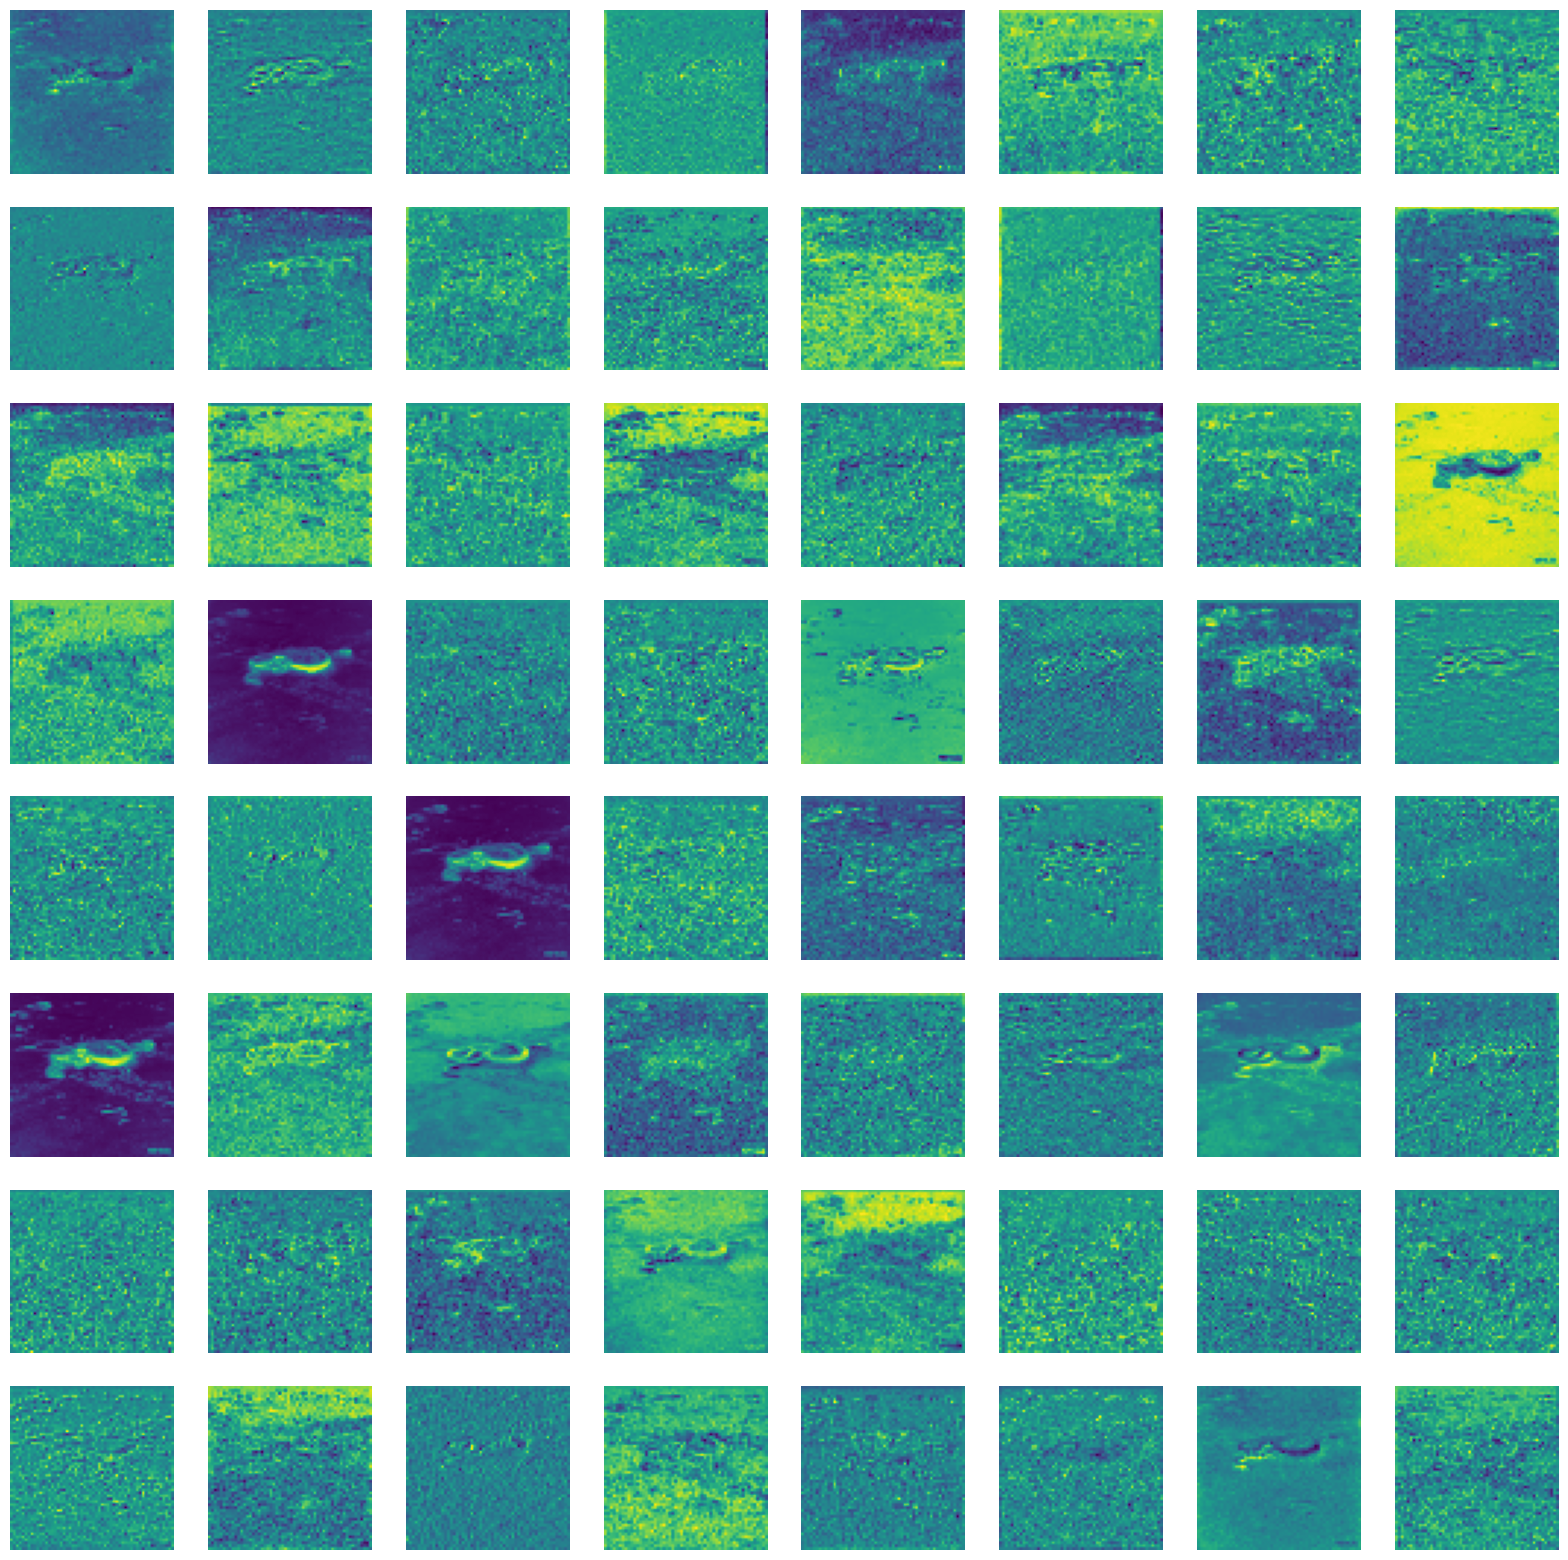

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

for module, output in outputs.items():
    op = output.tolist()

print(len(op[0][0]))
num_feature_maps = len(op[0])
grid_size = int(np.ceil(np.sqrt(num_feature_maps)))  # Create a square grid
plt.figure(figsize=(20, 20))

# Loop through the feature maps and plot them
for i in range(num_feature_maps):
    plt.subplot(8, 8, i + 1)
    plt.imshow(op[0][i], cmap='viridis')
    plt.axis('off')
plt.show()

56


ValueError: num must be an integer with 1 <= num <= 64, not 65

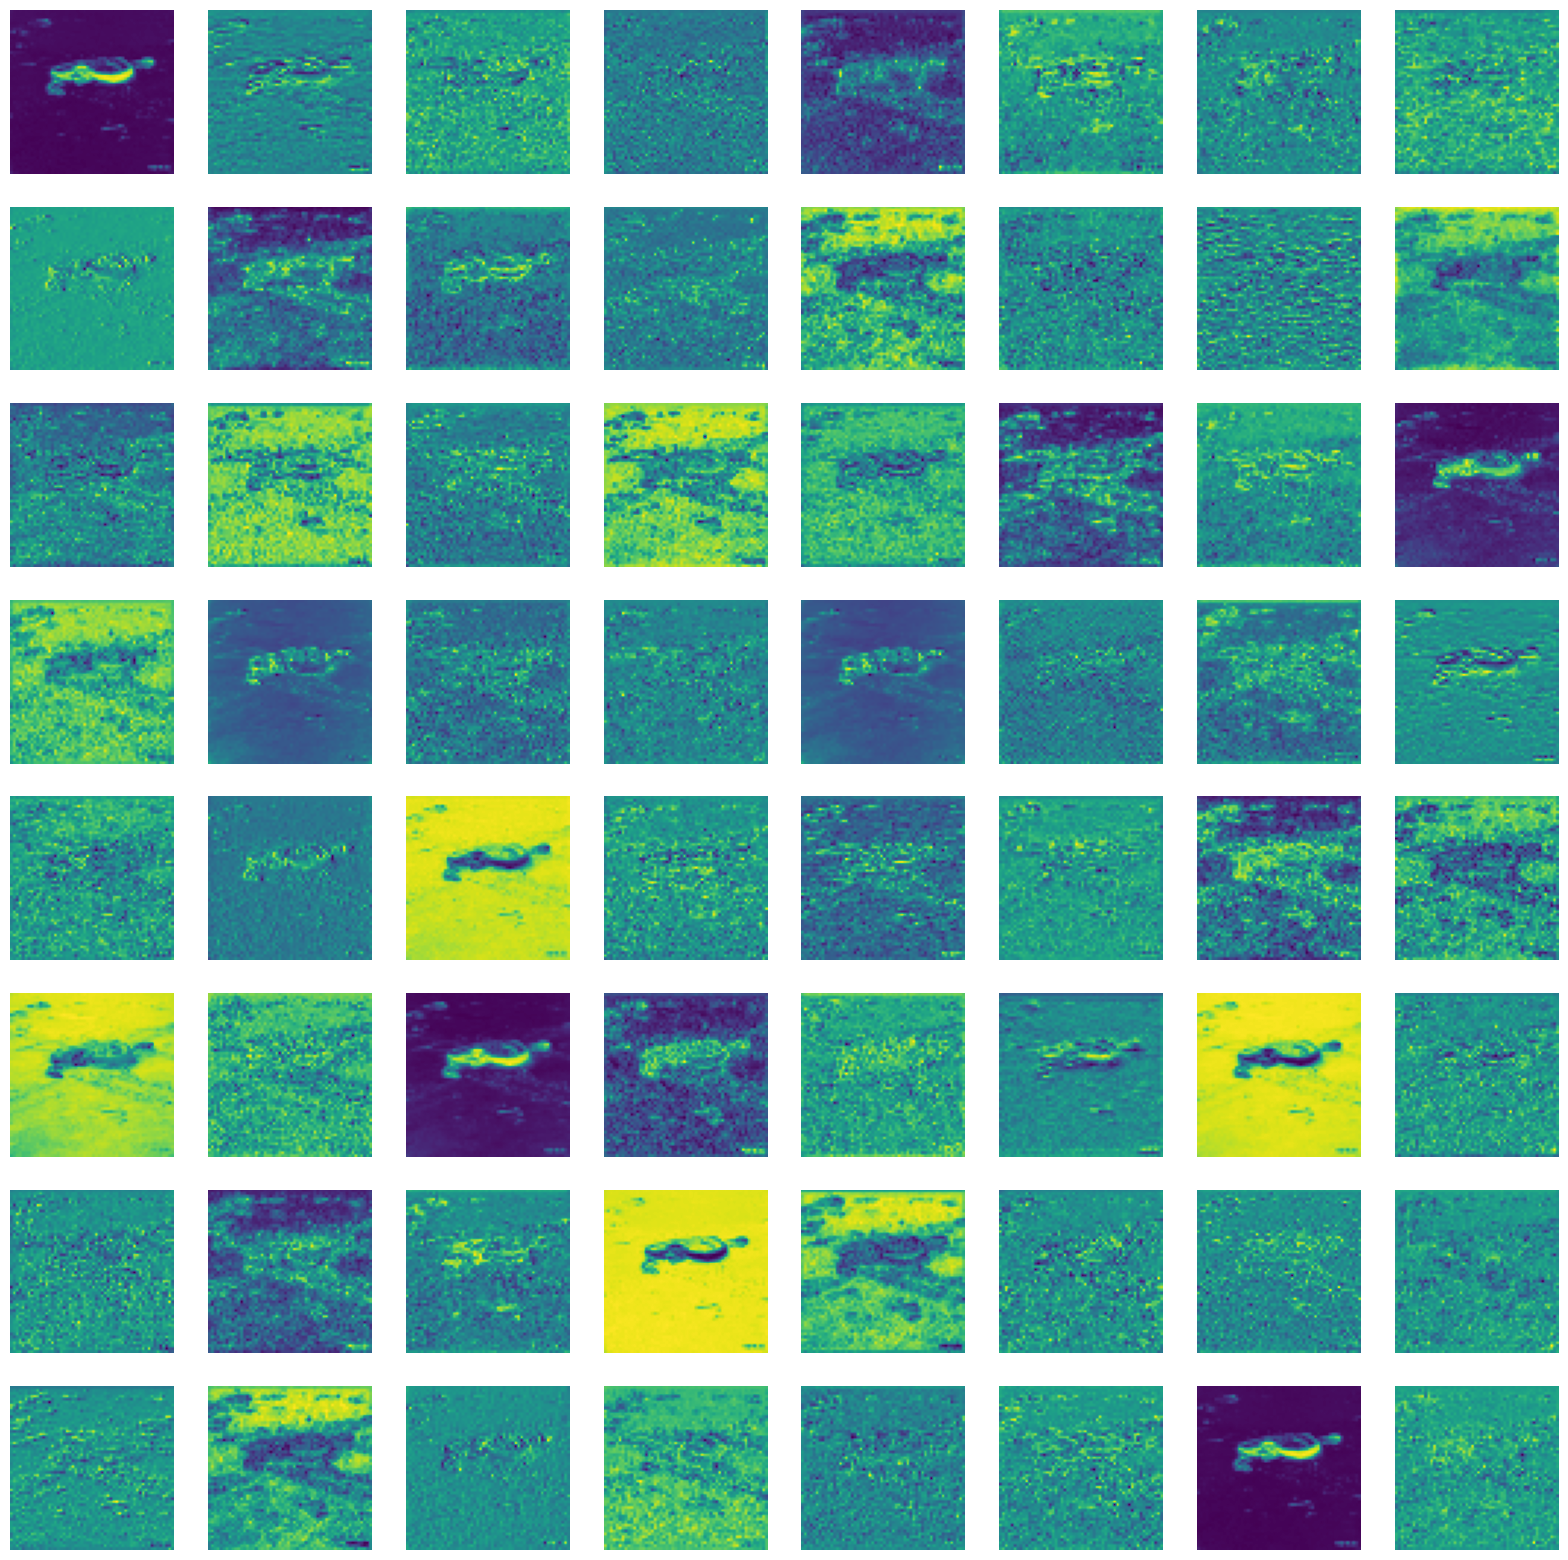

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

for module, output in outputs.items():
    op = output.tolist()

print(len(op[0][0]))
num_feature_maps = len(op[0])
grid_size = int(np.ceil(np.sqrt(num_feature_maps)))  # Create a square grid
plt.figure(figsize=(20, 20))

# Loop through the feature maps and plot them
for i in range(num_feature_maps):
    plt.subplot(8, 8, i + 1)
    plt.imshow(op[0][i], cmap='viridis')
    plt.axis('off')
plt.show()

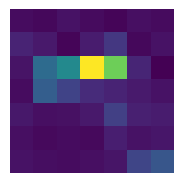

In [ ]:
num_feature_maps = len(op[0])
grid_size = int(np.ceil(np.sqrt(num_feature_maps)))  # Create a square grid
plt.figure(figsize=(20, 20))

# Loop through the feature maps and plot them
# for i in range(num_feature_maps):
plt.subplot(8, 8, 1)
plt.imshow(op[0][1023], cmap='viridis')
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import json

# Load the JSON file
json_file_path = '/content/Invert_representations.json'
with open(json_file_path, 'r') as f:
    output = json.load(f)
feature_maps = list(output.values())#.detach().cpu().numpy()  # Get the first (and only) image's feature maps
num_feature_maps = len(feature_maps[0])
print(output)
# plt.figure(figsize=(20, 20))
# plt.subplot(1, 1, 1)  # Adjust grid size as needed
# plt.imshow(feature_maps[0], cmap='viridis')
# plt.axis('off')
# plt.show()
# print(num_feature_maps)
# Plot each feature map
plt.figure(figsize=(20, 20))
# for i in range(num_feature_maps):
#     plt.subplot(8, 8, i + 1)  # Adjust grid size as needed
#     plt.imshow(feature_maps[i], cmap='viridis')
#     plt.axis('off')
# plt.show()

#CODE FOR INTERMEDIATE LAYER REPRESENTATIONS USING CUSTOM MODEL

In [ ]:
##CODE FOR INTERMEDIATE LAYER REPRESENTATIONS USING CUSTOM MODEL
import torch
from torchvision import models
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
weights = ConvNeXt_Base_Weights.IMAGENET1K_V1
model = convnext_base(weights=weights)

# # Load pre-trained ConvNeXt model
# model = models.convnext_base(pretrained=True)

# Define a custom model to fetch representations
class ConvNeXtWithRepresentations(nn.Module):
    def __init__(self, original_model):
        super(ConvNeXtWithRepresentations, self).__init__()
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # Exclude the final classification layer
        self.classifier = original_model.classifier

    def forward(self, x):
        representations = self.features(x)
        flattened = representations.view(representations.size(0), -1)
        output = self.classifier(flattened)
        return representations, output

# # Instantiate the custom model
# custom_model = ConvNeXtWithRepresentations(model)

# # Prepare some input data
# dummy_input = torch.randn(1, 3, 224, 224)

# # Fetch the representations
# custom_model.eval()
# with torch.no_grad():
#     representations, output = custom_model(dummy_input)

# # Print the shape of the fetched representations
# print(representations.shape)


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:06<00:00, 58.7MB/s]


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from torchvision.transforms import v2
import re
transforms = v2.Compose([
    v2.ToImage(),  # Convert to tensor, only needed if you had a PIL image
    v2.ToDtype(torch.uint8, scale=True),  # optional, most input are already uint8 at this point
    v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def _load_image(path):
# try:
    im = Image.open(path)
    im = im.resize((224,224))
    # except:
    #     print("ERROR IMG LOADED: ", path)
    #     random_img = np.random.rand(224, 224, 3) * 255
    #     im = Image.fromarray(np.uint8(random_img))
    return im
img_path = "/content/transformations_1/AddToHueAndSaturation/ILSVRC2012_val_00000001.JPEG"
image = _load_image(img_path).convert('RGB')

image = transforms(image)

In [ ]:
print(image.shape)

torch.Size([3, 224, 224])


In [ ]:
image = image.cuda(non_blocking=True)
with torch.cuda.amp.autocast(enabled=False):
    output = model(image)
res_model.append(np.argmax(output.cpu().detach().numpy(), axis=1))

# Instantiate the custom model

In [ ]:
# Instantiate the custom model
# image = image.unsqueeze(0)
# print(image.shape)
custom_model = ConvNeXtWithRepresentations(model)

# Prepare some input data
dummy_input = torch.randn(1, 3, 224, 224)

# Fetch the representations
custom_model.eval()



ConvNeXtWithRepresentations(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
            (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
            (3): Linear(in_features=128, out_features=512, bias=True)
            (4): GELU(approximate='none')
            (5): Linear(in_features=512, out_features=128, bias=True)
            (6): Permute()
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): CNBlock(
          (block): Sequential(
            (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
            (1): Permute()
         

------------------------------------------------------------